### Phase 4 (Modeling)

| Target | Description | Data Type | Analysis Type |
| --- | --- | --- | --- |
| Price| The price of the vehicle | int64 | Regression |

### Import libraries

In [1]:
import json
import pandas as pd
import numpy as np
import joblib
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,  root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Load your cleaned dataset

In [2]:
from pathlib import Path

DATA_DIR = Path("./trained_model_files/")


df = pd.read_csv(DATA_DIR / "cars_price_prediction_latest.csv")
df.describe()
FEATURE_COLUMNS = [
	"engine_type",
	"fuel_type",
	"transmission",
	"body_type",
	"has_incidents",
	"wheel_system",
	"horsepower",
	"maximum_seating",
	"mileage",
	"torque",
	"year",
	"combined_fuel_economy",
	"legroom",
	"major_options_count",
	"size_of_vehicle"
]

In [3]:
df.sample(5)

,engine_type,fuel_type,transmission,body_type,has_incidents,wheel_system,horsepower,maximum_seating,mileage,torque,year,combined_fuel_economy,legroom,major_options_count,size_of_vehicle,price
126162,6.0,5.0,3,5,0,3,147.0,5,1.0,132.0,2021,28.0,79.900000,4.0,415.8,9.915663
2417610,9.0,5.0,0,6,0,3,302.0,5,2258.0,267.0,2020,27.0,81.600000,6.0,455.1,10.670350
411242,9.0,5.0,0,5,0,0,241.0,5,43390.0,390.0,2017,21.5,78.900000,9.0,483.3,10.264652
570461,8.0,5.0,0,1,0,2,630.0,2,17387.0,443.0,2018,16.5,80.166305,5.0,436.4,12.428816
900742,9.0,5.0,0,6,0,3,268.0,5,35910.0,248.0,2017,25.5,81.900000,10.0,450.3,10.194028


### Explore data

In [4]:
display(df.info())
display(df.describe())
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2625910 entries, 0 to 2625909
Data columns (total 16 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   engine_type            float64
 1   fuel_type              float64
 2   transmission           int64  
 3   body_type              int64  
 4   has_incidents          int64  
 5   wheel_system           int64  
 6   horsepower             float64
 7   maximum_seating        int64  
 8   mileage                float64
 9   torque                 float64
 10  year                   int64  
 11  combined_fuel_economy  float64
 12  legroom                float64
 13  major_options_count    float64
 14  size_of_vehicle        float64
 15  price                  float64
dtypes: float64(10), int64(6)
memory usage: 320.5 MB


None

,engine_type,fuel_type,transmission,body_type,has_incidents,wheel_system,horsepower,maximum_seating,mileage,torque,year,combined_fuel_economy,legroom,major_options_count,size_of_vehicle,price
count,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06,2.625910e+06
mean,7.074013e+00,4.878645e+00,2.117491e-01,4.889393e+00,6.587811e-02,2.174839e+00,2.436271e+02,5.438198e+00,2.083565e+04,2.642732e+02,2.018348e+03,2.614862e+01,8.024379e+01,6.325709e+00,4.703230e+02,1.022088e+01
std,2.008846e+00,6.564600e-01,5.129378e-01,1.241023e+00,2.480690e-01,1.220162e+00,9.050989e+01,1.141106e+00,2.850102e+04,1.079547e+02,3.233862e+00,7.641223e+00,3.322577e+00,3.465664e+00,4.873382e+01,5.104482e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.300000e+01,2.000000e+00,0.000000e+00,6.800000e+01,1.915000e+03,9.500000e+00,0.000000e+00,1.000000e+00,3.102000e+02,5.545177e+00
25%,6.000000e+00,5.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,2.000000e+00,1.700000e+02,5.000000e+00,5.000000e+00,1.810000e+02,2.017000e+03,2.250000e+01,7.820000e+01,4.000000e+00,4.402000e+02,9.899580e+00
50%,6.000000e+00,5.000000e+00,0.000000e+00,5.000000e+00,0.000000e+00,3.000000e+00,2.280000e+02,5.000000e+00,1.099000e+03,2.642732e+02,2.020000e+03,2.500000e+01,8.016630e+01,6.000000e+00,4.565000e+02,1.022176e+01
75%,9.000000e+00,5.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,3.000000e+00,3.000000e+02,6.000000e+00,3.524600e+04,2.750000e+02,2.020000e+03,2.850000e+01,8.170000e+01,8.000000e+00,4.854000e+02,1.057252e+01
max,1.000000e+01,7.000000e+00,3.000000e+00,8.000000e+00,1.000000e+00,4.000000e+00,1.001000e+03,1.500000e+01,1.091460e+05,9.440000e+02,2.021000e+03,1.270000e+02,1.049636e+02,5.900000e+01,7.020000e+02,1.500943e+01


engine_type              0
fuel_type                0
transmission             0
body_type                0
has_incidents            0
wheel_system             0
horsepower               0
maximum_seating          0
mileage                  0
torque                   0
year                     0
combined_fuel_economy    0
legroom                  0
major_options_count      0
size_of_vehicle          0
price                    0
dtype: int64

### Feature Selection

In [5]:
X = df.drop(set(df.columns)-set(FEATURE_COLUMNS), axis=1)  # drop target column from features
y = df['price']

### Train-Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
display(X_train.columns)
display(X_train.dtypes)
X_train.head()

Index(['engine_type', 'fuel_type', 'transmission', 'body_type',
       'has_incidents', 'wheel_system', 'horsepower', 'maximum_seating',
       'mileage', 'torque', 'year', 'combined_fuel_economy', 'legroom',
       'major_options_count', 'size_of_vehicle'],
      dtype='object')

engine_type              float64
fuel_type                float64
transmission               int64
body_type                  int64
has_incidents              int64
wheel_system               int64
horsepower               float64
maximum_seating            int64
mileage                  float64
torque                   float64
year                       int64
combined_fuel_economy    float64
legroom                  float64
major_options_count      float64
size_of_vehicle          float64
dtype: object

,engine_type,fuel_type,transmission,body_type,has_incidents,wheel_system,horsepower,maximum_seating,mileage,torque,year,combined_fuel_economy,legroom,major_options_count,size_of_vehicle
2041764,3.0,5.0,1,5,0,2,182.0,5,0.0,176.000000,2020,29.5,82.3,6.161011,466.0
2371009,9.0,5.0,0,4,0,0,285.0,5,22.0,260.000000,2020,19.5,79.5,7.000000,526.1
1041671,9.0,5.0,0,4,0,0,308.0,5,2.0,369.000000,2021,20.5,80.8,7.000000,516.5
1697394,9.0,5.0,0,5,0,0,270.0,7,2.0,278.000000,2020,25.0,74.6,5.000000,470.3
2150907,10.0,0.0,0,4,0,0,475.0,5,4.0,264.273155,2020,25.0,87.5,11.000000,678.2


### Scale your features

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train Models

**LinearRegression**

In [9]:
# Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)


LinearRegression()

**XGBRegressor**

In [10]:
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
# Predict LinearRegression
lr_pred = lr_model.predict(X_test_scaled)

# Metrics
rmse = root_mean_squared_error(y_test, lr_pred)
mae = mean_absolute_error(y_test, lr_pred)
r2 = r2_score(y_test, lr_pred)

# Print results
print("Evaluation Metrics for Price Prediction (Linear Regression)")
print(f"RMSE       : {rmse:.4f}")
print(f"MAE        : {mae:.4f}")
print(f"R² Score   : {r2:.4f}")


Evaluation Metrics for Price Prediction (Linear Regression)
RMSE       : 0.2575
MAE        : 0.1882
R² Score   : 0.7462


In [12]:
#Predict XGBoost
xgb_pred = xgb_model.predict(X_test)

rmse = root_mean_squared_error(y_test, xgb_pred)
mae = mean_absolute_error(y_test, xgb_pred)
r2 = r2_score(y_test, xgb_pred)

print("Evaluation Metrics for Price Prediction (XGBoost)")
print(f"RMSE       : {rmse:.4f}")
print(f"MAE        : {mae:.4f}")
print(f"R² Score   : {r2:.4f}")


Evaluation Metrics for Price Prediction (XGBoost)
RMSE       : 0.1433
MAE        : 0.1036
R² Score   : 0.9214


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout


assert X_train_scaled.shape[0] == y_train.shape[0], "check size X_train and y_train gap!"
assert X_test_scaled.shape[0] == y_test.shape[0], "check size X_test and y_test gap!"

mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])


mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
mlp_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=15, batch_size=512, callbacks=[early_stopping], verbose=1)

# Predict
mlp_pred = mlp_model.predict(X_test_scaled)
if mlp_pred.ndim > 1:
    mlp_pred = mlp_pred.flatten()

# Evaluation
print("MLP RMSE:", np.sqrt(mean_squared_error(y_test, mlp_pred)))
print("MLP MAE:", mean_absolute_error(y_test, mlp_pred))
print("MLP R²:", r2_score(y_test, mlp_pred))


Epoch 1/15


c:\Users\iftak\miniconda3\envs\aida\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3283/3283 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 9.7011 - mae: 2.0940 - val_loss: 0.0824 - val_mae: 0.2245
Epoch 2/15
3283/3283 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 1.3898 - mae: 0.9356 - val_loss: 0.0626 - val_mae: 0.1887
Epoch 3/15
3283/3283 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.7836 - mae: 0.7006 - val_loss: 0.0525 - val_mae: 0.1734
Epoch 4/15
3283/3283 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.3569 - mae: 0.4700 - val_loss: 0.0420 - val_mae: 0.1508
Epoch 5/15
3283/3283 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.1219 - mae: 0.2693 - val_loss: 0.0372 - val_mae: 0.1413
Epoch 6/15
3283/3283 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0476 - mae: 0.1623 - val_loss: 0.0338 - val_mae: 0.1339
Epoch 7/15
3283/3283 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0401 - mae: 0.1475 - val_loss: 0.0329 - val_mae: 0.1328
Epoch 8/15
3283/3283 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0383 - mae: 0.1437 - val_loss: 0.0340 - val_mae: 0.1345
Epoch 9/15
3283/3283 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/st

In [14]:
# Gather evaluation results
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_mae = mean_absolute_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_pred))
mlp_mae = mean_absolute_error(y_test, mlp_pred)
mlp_r2 = r2_score(y_test, mlp_pred)

# Create DataFrame
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": ["Linear Regression","XGBoost", "MLP (Neural Network)"],
    "RMSE": [lr_rmse, xgb_rmse, mlp_rmse],
    "MAE": [lr_mae, xgb_mae, mlp_mae],
    "R² Score": [lr_r2, xgb_r2, mlp_r2]
})

print(comparison_df)


                  Model      RMSE       MAE  R² Score
0     Linear Regression  0.257470  0.188230  0.746222
1               XGBoost  0.143330  0.103593  0.921354
2  MLP (Neural Network)  0.174713  0.127182  0.883143


#### Visualize Performance

##### a. Actual vs Predicted Plot

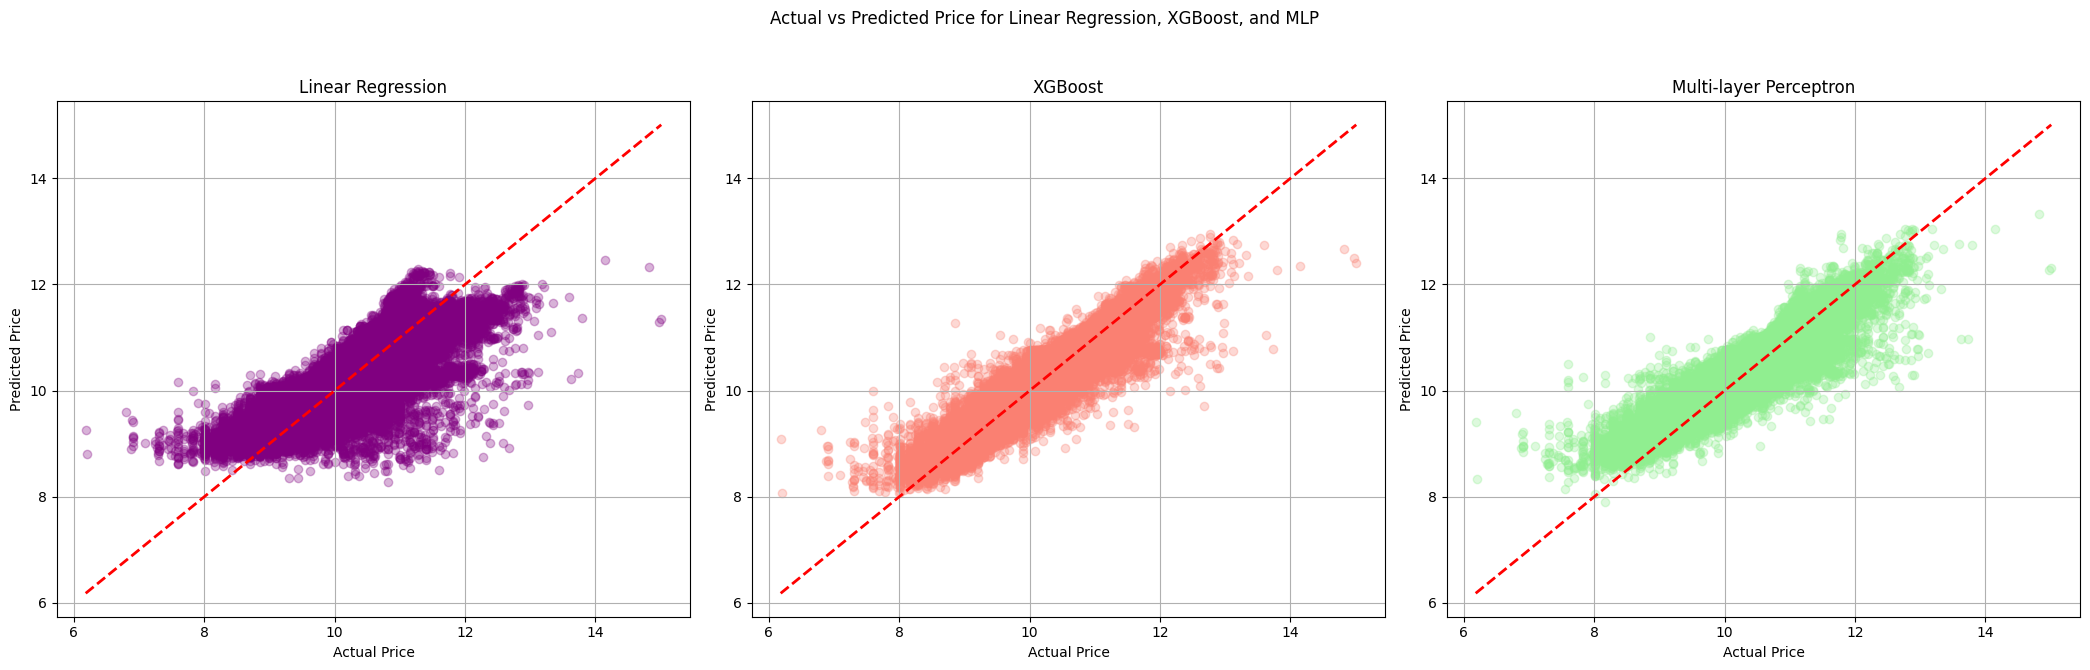

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('Actual vs Predicted Price for Linear Regression, XGBoost, and MLP')

# Actual vs Predicted Linear Regression
axes[0].scatter(y_test, lr_pred, alpha=0.3, color='purple')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title('Linear Regression')
axes[0].grid(True)

# Actual vs Predicted XGBoost
axes[1].scatter(y_test, xgb_pred, alpha=0.3, color='salmon')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Price')
axes[1].set_ylabel('Predicted Price')
axes[1].set_title('XGBoost')
axes[1].grid(True)

axes[2].scatter(y_test, mlp_pred, alpha=0.3, color='lightgreen')
axes[2].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[2].set_xlabel('Actual Price')
axes[2].set_ylabel('Predicted Price')
axes[2].set_title('Multi-layer Perceptron')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##### b. Residual Plot

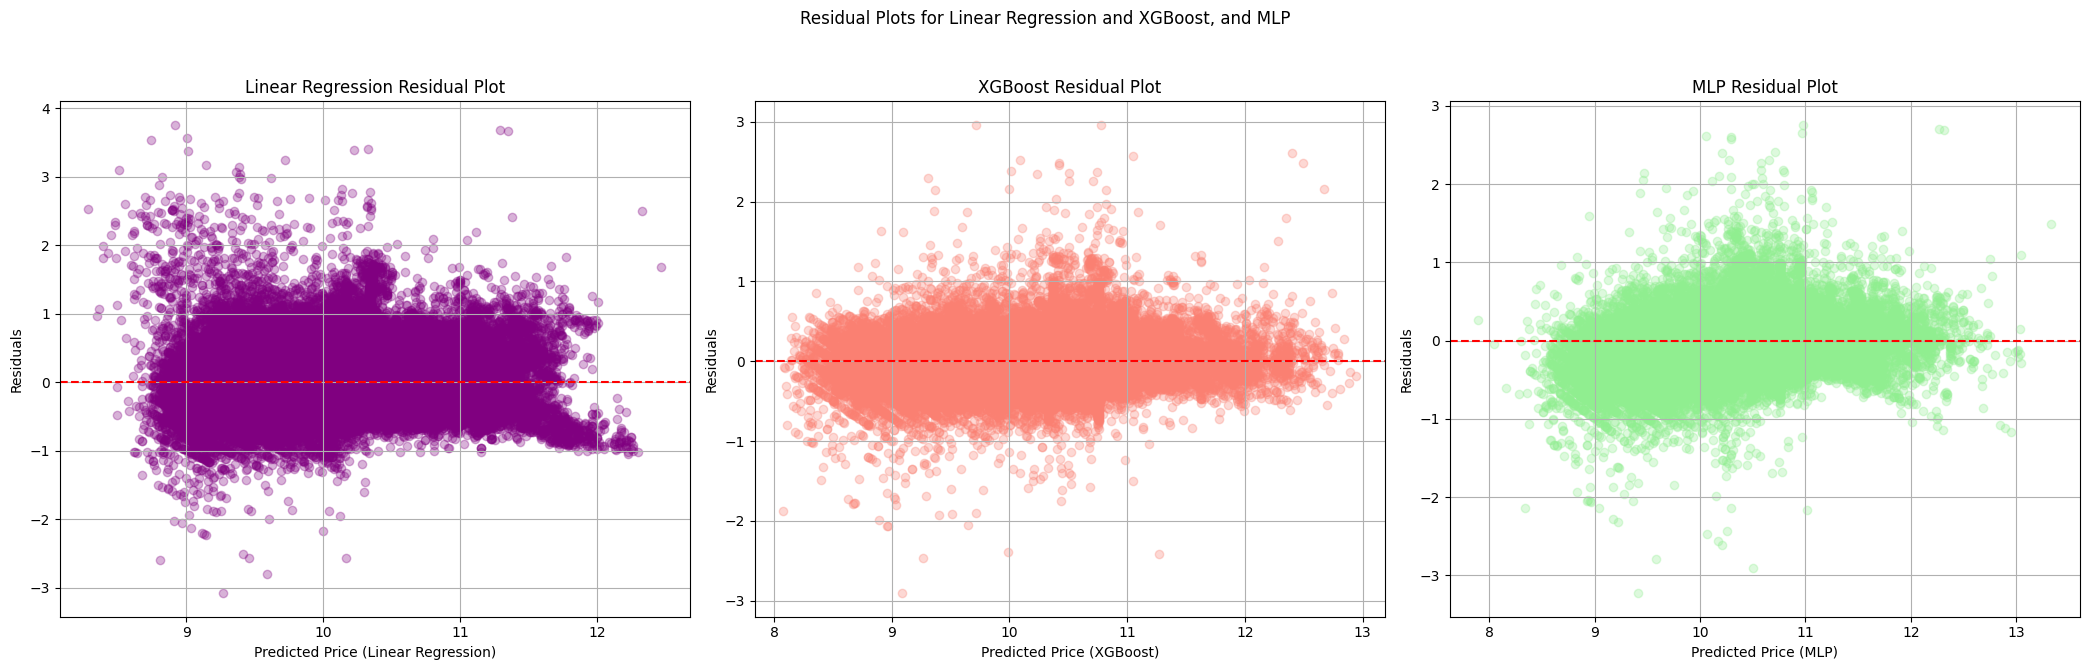

In [16]:
residuals_lr = y_test - lr_pred
residuals_xgb = y_test - xgb_pred
residuals_mlp = y_test - mlp_pred

fig, axes = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('Residual Plots for Linear Regression and XGBoost, and MLP')

# residual Linear Regression
axes[0].scatter(lr_pred, residuals_lr, alpha=0.3, color='purple')
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel('Predicted Price (Linear Regression)')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Linear Regression Residual Plot')
axes[0].grid(True)

# residual  XGBoost
axes[1].scatter(xgb_pred, residuals_xgb, alpha=0.3, color='salmon')
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel('Predicted Price (XGBoost)')
axes[1].set_ylabel('Residuals')
axes[1].set_title('XGBoost Residual Plot')
axes[1].grid(True)

axes[2].scatter(mlp_pred, residuals_mlp, alpha=0.3, color='lightgreen')
axes[2].axhline(0, color='red', linestyle='--')
axes[2].set_xlabel('Predicted Price (MLP)')
axes[2].set_ylabel('Residuals')
axes[2].set_title('MLP Residual Plot')
axes[2].grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

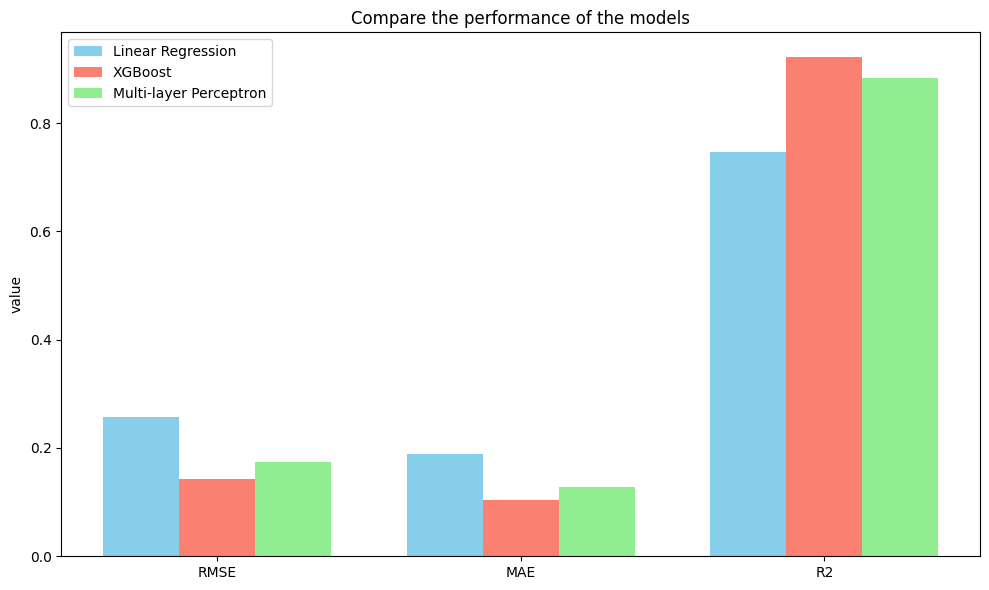

In [17]:
import matplotlib.pyplot as plt
import numpy as np


models = ['Linear Regression', 'XGBoost', 'Multi-layer Perceptron']

metrics = ['RMSE', 'MAE', 'R2']

values = {
    'Linear Regression': [lr_rmse, lr_mae, lr_r2],
    'XGBoost': [xgb_rmse, xgb_mae, xgb_r2],
    'Multi-layer Perceptron': [mlp_rmse, mlp_mae, mlp_r2]
}

x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, values['Linear Regression'], width, label='Linear Regression', color='skyblue')
rects2 = ax.bar(x, values['XGBoost'], width, label='XGBoost', color='salmon')
rects3 = ax.bar(x + width, values['Multi-layer Perceptron'], width, label='Multi-layer Perceptron', color='lightgreen')

ax.set_ylabel('value')
ax.set_title('Compare the performance of the models')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()
plt.show()

##### Hyperparameter Tuning for MLP (Keras)

In [18]:
models = []
results = []

param_sets = [
    {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.1,  "subsample": 0.8, "colsample_bytree": 0.8 },
    {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.01, "subsample": 0.7, "colsample_bytree": 0.9 },
    {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.05,  "subsample": 0.9, "colsample_bytree": 0.7 }
]

for i, params in enumerate(param_sets):
    model = xgb.XGBRegressor(
        **params
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    models.append(model)
    results.append({
        'Model': f'model_{i+1}',
        'Params': params,
        'RMSE': root_mean_squared_error(y_test, preds),
        'MAE': mean_absolute_error(y_test, preds),
        'R2': r2_score(y_test, preds)
    })


results_df = pd.DataFrame(results)
results_df

,Model,Params,RMSE,MAE,R2
0,model_1,"{'n_estimators': 100, 'max_depth': 6, 'learnin...",0.143856,0.104232,0.920775
1,model_2,"{'n_estimators': 150, 'max_depth': 6, 'learnin...",0.224681,0.167144,0.806743
2,model_3,"{'n_estimators': 200, 'max_depth': 6, 'learnin...",0.143627,0.103900,0.921027


- model_1 & model_3 are almost equivalent, both have R2 = 0.92 → The configuration is working stably and well.
- model_2 has learning_rate = 0.01 but the number of trees is not large enough (only 150), leading to underfitting => poor results.

Solution test:  
Smaller learning_rate is better when n_estimators is higher   
- Try n_estimators  300–500 with learning_rate=0.01  
- Try max_depth=5 and max_depth=7 to control overfitting  
- Try again colsample_bytree = 0.75 or 0.85 to control noise  

In [19]:
models = []
results = []

param_sets = [
    {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01,  "subsample": 0.8, "colsample_bytree": 0.8 },
    {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.03,  "subsample": 0.9, "colsample_bytree": 0.75 },
    {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.05,  "subsample": 0.8, "colsample_bytree": 0.85 }
]


for i, params in enumerate(param_sets):
    model = xgb.XGBRegressor(
        **params
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    models.append(model)
    results.append({
        'Model': f'model_{i+1}',
        'Params': params,
        'RMSE': root_mean_squared_error(y_test, preds),
        'MAE': mean_absolute_error(y_test, preds),
        'R2': r2_score(y_test, preds)
    })


results_df = pd.DataFrame(results)
results_df

,Model,Params,RMSE,MAE,R2
0,model_1,"{'n_estimators': 300, 'max_depth': 6, 'learnin...",0.175128,0.128419,0.882588
1,model_2,"{'n_estimators': 250, 'max_depth': 6, 'learnin...",0.149311,0.108552,0.914653
2,model_3,"{'n_estimators': 200, 'max_depth': 7, 'learnin...",0.134438,0.096691,0.930809


Highest R2 (0.93) => explains **93%** of data variance  
Compared to previous times, this model improves significantly thanks to **max_depth=7** and **learning_rate=0.05.**   

In [20]:
models = []
results = []

param_sets = [
    {'n_estimators': 400, 'max_depth': 8, 'learning_rate': 0.05,  "subsample": 0.8, "colsample_bytree": 0.8 }
]

for i, params in enumerate(param_sets):
    model = xgb.XGBRegressor(
        **params
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    models.append(model)
    results.append({
        'Model': f'model_{i+1}',
        'Params': params,
        'RMSE': root_mean_squared_error(y_test, preds),
        'MAE': mean_absolute_error(y_test, preds),
        'R2': r2_score(y_test, preds)
    })

results_df = pd.DataFrame(results)
results_df

,Model,Params,RMSE,MAE,R2
0,model_1,"{'n_estimators': 400, 'max_depth': 8, 'learnin...",0.12119,0.085985,0.943774


**RESULT** : RMSE decreased by ~15%, MAE decreased by ~17%, and R2 increased from **0.92 → 0.94** => the model predicted significantly more accurately.  
- Increasing **n_estimators** to 400 helps the model learn deeper (with a small **learning_rate**).  
- Reducing **learning_rate** helps the weight update smoother, avoiding early overfitting.  
- Increasing **max_depth** to 8 helps the model exploit more complex information in the data.  

In [21]:
xgb_model = xgb.XGBRegressor(
    n_estimators=512,
    max_depth=24,
    max_leaves=800,
    learning_rate=0.125,
    gamma=0.005,
    random_state=31
)

xgb_model.fit(X_train, y_train)

#Predict XGBoost
xgb_pred = xgb_model.predict(X_test)

rmse = root_mean_squared_error(y_test, xgb_pred)
mae = mean_absolute_error(y_test, xgb_pred)
r2 = r2_score(y_test, xgb_pred)

print("Evaluation Metrics for Price Prediction (XGBoost)")
print(f"RMSE       : {rmse:.4f}")
print(f"MAE        : {mae:.4f}")
print(f"R² Score   : {r2:.4f}")


Evaluation Metrics for Price Prediction (XGBoost)
RMSE       : 0.1130
MAE        : 0.0786
R² Score   : 0.9511


> This seem to perform better then the other XGB models, the parameters were optimized by experimenting with each individually. the accuracy is increased from **94%** -> **95%**.

**The result reflects the best model we have is XGBoost and now we export this model to proceed to the next step.**

In [22]:
xgb_model.save_model(DATA_DIR / 'xgb_price_prediction.ubj')
mlp_model.save(DATA_DIR / 'mlp_price_prediction.keras')
joblib.dump(lr_model, DATA_DIR / 'lr_price_prediction.pkl')
joblib.dump(scaler, DATA_DIR / 'scaler_price_prediction.pkl')
with open(DATA_DIR / 'feature_columns.json', 'w+') as f:
    json.dump(list(X_train.columns), fp=f)

In [23]:
X.join(y).to_csv(DATA_DIR / 'car_X_Y_original_dataset.csv', index=False)

### Prepare function for retraining with extended dataset
Intention for the below function is to use in the api so that new data can be added and model can be retrained without any manual intervention on the server.

In [24]:
import json
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error, mean_squared_error

# MLP model requirements
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dropout
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
set_global_policy('mixed_float16')  # Enable mixed precision for faster training on GPU
import tensorflow as tf


FEATURE_COLUMNS = [
	"engine_type",
	"fuel_type",
	"transmission",
	"body_type",
	"has_incidents",
	"wheel_system",
	"horsepower",
	"maximum_seating",
	"mileage",
	"torque",
	"year",
	"combined_fuel_economy",
	"legroom",
	"major_options_count",
	"size_of_vehicle",
]
TARGET_COLUMNS = ['price']
REQUIRED_COLUMNS = FEATURE_COLUMNS+TARGET_COLUMNS





def evaluate_model(y_true, y_pred):
	return {
		"mse": mean_squared_error(y_true, y_pred),
		"mae": mean_absolute_error(y_true, y_pred),
		"rmse": root_mean_squared_error(y_true, y_pred),
		"r2": r2_score(y_true, y_pred)
	}

def retrain(data_files=[],
			save_models=True, 
			update_models_in_memory=True, 
			save_combined_dataset=True,
			train_mlp=True,
):
	loaded_dfs = []
	for file in data_files:
		df = pd.read_csv(file)
		
		# Check for missing columns
		missing_columns = set(REQUIRED_COLUMNS) - set(df.columns)
		if len(missing_columns)>0:
			raise ValueError(f"File: {file} is missing {missing_columns} required columns")
		
		# cleanup extra columns
		extra_columns = set(df.columns) - set(REQUIRED_COLUMNS)
		df.drop(columns=extra_columns, inplace=True)
		
		# add to loaded dataframes
		loaded_dfs.append(df)


	# combine the loaded dataframes
	combined_df = pd.concat(loaded_dfs, axis=0)
	combined_df.dropna(inplace=True)
	combined_df.reset_index()
	# print(combined_df.isna.sum()) # debug
	 

	# split data for training and testing
	X, y = combined_df[FEATURE_COLUMNS], combined_df[TARGET_COLUMNS]
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)


	# scale data	
	std_scaler = StandardScaler()
	X_train_scaled = std_scaler.fit_transform(X_train)
	X_test_scaled = std_scaler.transform(X_test)


	# train LR model
	lr_model = LinearRegression()
	lr_model.fit(X_train_scaled, y_train)
	# evaluate model
	y_pred_lr = lr_model.predict(X_test_scaled)
	lr_metrics = evaluate_model(y_test, y_pred_lr)


	# train XGB_model
	xgb_model = xgb.XGBRegressor(
		n_estimators=512,
		max_depth=24,
		max_leaves=800,
		learning_rate=0.125,
		gamma=0.005,
		random_state=31
	)
	xgb_model.fit(X_train_scaled, y_train)
	# evaluate model
	y_pred_xgb = xgb_model.predict(X_test_scaled)
	xgb_metrics = evaluate_model(y_test, y_pred_xgb)


	# if train_mlp:
	# 	# prepare mlp model
	# 	assert X_train_scaled.shape[0] == y_train.shape[0], "check size X_train and y_train gap!"
	# 	assert X_test_scaled.shape[0] == y_test.shape[0], "check size X_test and y_test gap!"
	# 	mlp_model = Sequential([
	# 		Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
	# 		Dropout(0.2),
	# 		Dense(32, activation='relu'),
	# 		Dropout(0.2),
	# 		Dense(1)
	# 	])
	# 	mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

	# 	# train mlp_model
	# 	early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
	# 	mlp_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=20, batch_size=32, callbacks=[early_stopping], verbose=True)
	# 	# evaluate model
	# 	y_pred_mlp = mlp_model.predict(X_test_scaled)
	# 	mlp_metrics = evaluate_model(y_test, y_pred_mlp)
	# else:
	# 	mlp_model = None
	# 	mlp_metrics = {
	# 			"mse": 0,
	# 			"mae": 0,
	# 			"rmse": 0,
	# 			"r2": 0,
	# 		}
	#################
	# if train_mlp:
	# 	# Prepare MLP model
	# 	assert X_train_scaled.shape[0] == y_train.shape[0], "check size X_train and y_train gap!"
	# 	assert X_test_scaled.shape[0] == y_test.shape[0], "check size X_test and y_test gap!"

	# 	mlp_model = Sequential([
	# 		Dense(24, activation='relu', input_shape=(X_train_scaled.shape[1],)),
	# 		Dropout(0.1),
	# 		Dense(16, activation='relu'),
	# 		Dropout(0.1),
	# 		Dense(1, dtype='float32')  # Output must be float32 even when using mixed precision
	# 	])
	# 	mlp_model.compile(
	# 		optimizer=Adam(learning_rate=0.001),
	# 		loss='mse',
	# 		metrics=['mae']
	# 	)

	# 	# Early stopping to avoid overfitting
	# 	early_stopping = EarlyStopping(
	# 		monitor='val_loss',
	# 		patience=3,  # patience is reduced for quicker stopping
	# 		restore_best_weights=True
	# 	)

	# 	# Train the model
	# 	mlp_model.fit(
	# 		X_train_scaled,
	# 		y_train,
	# 		validation_split=0.1,  # smaller validation split for faster training
	# 		epochs=10,             # reduced max epochs
	# 		batch_size=512,         # larger batch size
	# 		callbacks=[early_stopping],
	# 		verbose=True
	# 	)

	# 	# Evaluate
	# 	y_pred_mlp = mlp_model.predict(X_test_scaled)
	# 	mlp_metrics = evaluate_model(y_test, y_pred_mlp)
	# else:
	# 	mlp_model = None
	# 	mlp_metrics = {
	# 		"mse": 0,
	# 		"mae": 0,
	# 		"rmse": 0,
	# 		"r2": 0,
	# 	}
	###################
	if train_mlp:
		# Prepare MLP model
		assert X_train_scaled.shape[0] == y_train.shape[0], "Check size of X_train and y_train gap!"
		assert X_test_scaled.shape[0] == y_test.shape[0], "Check size of X_test and y_test gap!"
		
		# mlp_model = Sequential([
		# 	Dense(128, input_shape=(X_train_scaled.shape[1],)),
		# 	LeakyReLU(),
		# 	BatchNormalization(),
		# 	Dropout(0.3),
			
		# 	Dense(64),
		# 	LeakyReLU(),
		# 	BatchNormalization(),
		# 	Dropout(0.3),
			
		# 	Dense(32),
		# 	LeakyReLU(),
		# 	BatchNormalization(),
		# 	Dropout(0.2),
			
		# 	Dense(1)
		# ])

		# Best model 
		mlp_model = Sequential([
			Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
			Dropout(0.3),  # Increase dropout to reduce overfitting
			Dense(32, activation='relu'),
			Dropout(0.3),
			Dense(1)
		])

		
		mlp_model.compile(
			optimizer=Adam(learning_rate=0.001),
			loss=tf.keras.losses.Huber(),
			metrics=['mae']
		)

		# Callbacks: EarlyStopping and ReduceLROnPlateau
		early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
		reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)

		# Train the MLP model
		mlp_model.fit(
			X_train_scaled, y_train,
			validation_split=0.2,
			epochs=5,
			batch_size=512,
			callbacks=[early_stopping, reduce_lr],
			verbose=True
		)

		# Evaluate model
		y_pred_mlp = mlp_model.predict(X_test_scaled)
		mlp_metrics = evaluate_model(y_test, y_pred_mlp)
	else:
		mlp_model = None
		mlp_metrics = {
			"mse": 0,
			"mae": 0,
			"rmse": 0,
			"r2": 0,
		}
	###################


	if update_models_in_memory:
		# update global variables
		global STANDARD_SCALER, LR_MODEL, MLP_MODEL, XGB_MODEL
		STANDARD_SCALER = std_scaler
		LR_MODEL = lr_model
		MLP_MODEL = mlp_model
		XGB_MODEL = xgb_model
	
	# if save_models:
	# 	# Save files
	# 	xgb_model.save_model(XGB_MODEL_PATH)
	# 	if train_mlp:
	# 		mlp_model.save(MLP_MODEL_PATH)
	# 	joblib.dump(lr_model, LR_MODEL_PATH)
	# 	joblib.dump(std_scaler, SCALER_PATH)
	# 	with open(FEATURE_COLUMNS_PATH, 'w+') as f:
	# 		json.dump(list(X_train.columns), fp=f)
	
	# if save_combined_dataset:
	# 	combined_df.to_csv(COMBINED_DATASET_LATEST_FILE_PATH, columns=REQUIRED_COLUMNS, index=False)
	
	return {
		"models": {
			"linear_regression": lr_model,
			"xgboost": xgb_model,
			"mlp": mlp_model
		},
		"metrics": {
			"linear_regression": lr_metrics,
			"xgboost": xgb_metrics,
			"mlp": mlp_metrics
		}
	}



In [25]:
from pathlib import Path

DATA_DIR = Path(r"C:\Users\iftak\Desktop\jamk\2025 Spring\aida-project-spring-2025\docs\Phase 6\api\app\price_predictors\datasets")
data_files = [DATA_DIR/"additional_dataset.csv", DATA_DIR/"cars_price_prediction_latest.csv"]
data_files

[WindowsPath('C:/Users/iftak/Desktop/jamk/2025 Spring/aida-project-spring-2025/docs/Phase 6/api/app/price_predictors/datasets/additional_dataset.csv'),
 WindowsPath('C:/Users/iftak/Desktop/jamk/2025 Spring/aida-project-spring-2025/docs/Phase 6/api/app/price_predictors/datasets/cars_price_prediction_latest.csv')]

In [26]:
d = retrain(data_files)
d

Epoch 1/5


c:\Users\iftak\miniconda3\envs\aida\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3283/3283 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1.7074 - mae: 2.1435 - val_loss: 0.0498 - val_mae: 0.2502 - learning_rate: 0.0010
Epoch 2/5
3283/3283 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.5088 - mae: 0.8934 - val_loss: 0.0331 - val_mae: 0.1963 - learning_rate: 0.0010
Epoch 3/5
3283/3283 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.2438 - mae: 0.5711 - val_loss: 0.0220 - val_mae: 0.1544 - learning_rate: 0.0010
Epoch 4/5
3283/3283 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0739 - mae: 0.2980 - val_loss: 0.0215 - val_mae: 0.1528 - learning_rate: 0.0010
Epoch 5/5
3283/3283 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0266 - mae: 0.1716 - val_loss: 0.0216 - val_mae: 0.1530 - learning_rate: 0.0010
16412/16412 ━━━━━━━━━━━━━━━━━━━━ 7s 398us/step


c:\Users\iftak\miniconda3\envs\aida\Lib\site-packages\numpy\lib\_function_base_impl.py:564: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
c:\Users\iftak\miniconda3\envs\aida\Lib\site-packages\numpy\lib\_function_base_impl.py:564: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
c:\Users\iftak\miniconda3\envs\aida\Lib\site-packages\numpy\lib\_function_base_impl.py:564: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
c:\Users\iftak\miniconda3\envs\aida\Lib\site-packages\numpy\lib\_function_base_impl.py:564: RuntimeWarning: overflow encountered in cast
  scl = avg_as_array.dtype.type(a.size/avg_as_array.size)
c:\Users\iftak\miniconda3\envs\aida\Lib\site-packages\numpy\_core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


{'models': {'linear_regression': LinearRegression(),
  'xgboost': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=0.005, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.125, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=24,
               max_leaves=800, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=512,
               n_jobs=None, num_parallel_tree=None, ...),
  'mlp': <Sequential name=sequential_1, built=True>},
 'metrics': {'linear_regression': {'mse': 0.06566509462196143,
   'mae': 0.1878422856459705,
   'rmse': 0.25625

In [27]:
d['metrics']

{'linear_regression': {'mse': 0.06566509462196143,
  'mae': 0.1878422856459705,
  'rmse': 0.2562520138885965,
  'r2': 0.7479479500735053},
 'xgboost': {'mse': 0.012828265316784382,
  'mae': 0.07851140201091766,
  'rmse': 0.11326193064451218,
  'r2': 0.9507593512535095},
 'mlp': {'mse': 0.043701171875,
  'mae': 0.153076171875,
  'rmse': 0.2091064453125,
  'r2': 1.0}}

> Lowering the epoch number and increasing batch size made it faster to train the MLP model. After that Experimenting with the early stopping and layers help to get better accuracy. Final accuracy is from **0.887** to **1.0**.